In [1]:
import os
import re
import pandas as pd
from datetime import datetime
from datetime import timedelta

# import tkinter as tk
# from tkinter import filedialog


homedir = r"\\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol"


# subject_ids = ['RE602','RE603','RE604']

# tasks = ['pavlovian_spontanous_reaching_march23',
#          ['reaching_go_spout_feb23',
#          'reaching_go_spout_nov22'],
#          'reaching_go_spout_incr_break2_nov22',
#          ['reaching_go_spout_bar_nov22',
#           'reaching_go_spout_bar_mar23']]

subject_ids = ['kms058', 'kms060', 'kms061', 'kms062', 'kms063', 'kms064']

tasks = ['reaching_go_spout_bar_nov22', 'reaching_go_spout_bar_mar23']

In [2]:

items = os.listdir(homedir)

folders = [os.path.join(homedir, item) for item in items if os.path.isdir(
    os.path.join(homedir, item))]

print(folders)


['\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\exp01', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\JC301LS', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\debug', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\pavlovian_nobar_nodelay', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\go_rewarding_aversive_2', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\go_rewarding_aversive', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\reward_calibration', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\train_go_pavlovian', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\pavlovian_2s_delay', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\water_calibration', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\ReachTest', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycontrol\\check_light', '\\\\ettin\\Magill_Lab\\Julien\\Data\\head-fixed\\pycont

In [3]:
# folders = [r'\\ettin\Magill_Lab\Julien\Data\head-fixed\pycontrol\reaching_go_spout_bar_nov22']
filenames = []
folder_paths = []
for fld in folders:
    files = os.listdir(fld)

    # Filter out the files whose names don't match the regular expression pattern
    regex = re.compile('^(' + '|'.join(subject_ids) + ').+\.txt$')
    matching_files = [file for file in files if regex.match(file)]
    folders_ = [fld for file in files if regex.match(file)]

    if matching_files:
        filenames = filenames + matching_files
        folder_paths = folder_paths + folders_


df = pd.DataFrame({'folder': folder_paths, 'filename': filenames})


def get_date(text):
    match = re.search('\d{4}\-\d{2}\-\d{2}\-\d{6}', text)
    date_str = match.group(0)
    date_obj = datetime.strptime(date_str, '%Y-%m-%d-%H%M%S')
    return date_obj


df['datetime'] = df['filename'].apply(get_date)

df = df.sort_values(by='datetime', ascending=True)
df.reset_index(drop=True, inplace=True)
print(df)


                                                folder  \
0    \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
1    \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
2    \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
3    \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
4    \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
..                                                 ...   
287  \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
288  \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
289  \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
290  \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   
291  \\ettin\Magill_Lab\Julien\Data\head-fixed\pyco...   

                         filename            datetime  
0    kms058-2023-01-26-100537.txt 2023-01-26 10:05:37  
1    kms058-2023-01-26-100832.txt 2023-01-26 10:08:32  
2    kms058-2023-01-26-103650.txt 2023-01-26 10:36:50  
3    kms058-2023-01-26-104822.txt 2023-01-26 10:48:22  
4    kms060-2023-01-26-

In [4]:
df.loc[:,'filepath'] = [os.path.join(folder, filename) for folder, filename in zip(df['folder'],df['filename'])]

In [5]:
# task name
df.loc[0,'task_name'] = ''

for index, row in df.iterrows():

    if df.loc[index,'folder'] is not None and df.loc[index,'filename'] is not None:
        with open(os.path.join(df.loc[index,'folder'], df.loc[index,'filename']), 'r') as f:
            all_lines = [line.strip() for line in f.readlines() if line.strip()]

        m = None
        i = 0
        while m is None:
            m = re.match('^I\sTask\sname\s\:\s(.+)', all_lines[i])
            i += 1
        task_name = m.group(1)
        # print(f"{task_name}")    

        df.loc[index, 'task_name'] = task_name


df = df.loc[df['task_name'].isin(tasks)]
df.reset_index(drop=True, inplace=True)


In [6]:
# add columns

df.loc[:,'subject_id'] = [m.group(0) for m in df['filename'].apply(lambda x: re.match('\w+\d+', x))]
df.loc[0,'start_date'] = datetime.now()

var_name = 'hold_time_required_ms'

list_animals = []

for sbj_idx, sbj in enumerate(subject_ids):

    list_v = []
    list_last = []

    df_ = df.loc[df.subject_id == sbj,:] #TODO

    for index, row in df_.iterrows():

        with open(os.path.join(df_.loc[index,'folder'], df_.loc[index,'filename']), 'r') as f:
            all_lines = [line.strip() for line in f.readlines() if line.strip()]

        v_lines = [line for line in all_lines if bool(re.match('^V\s\d+\s', line))]

        m = None
        i = 0
        while m is None:
            m = re.match('^I\sSubject\sID\s\:\s(.+)', all_lines[i])
            i += 1
        subject_id = m.group(1)
        # print(f"{subject_id}")

        m = None
        i = 0
        while m is None:
            m = re.match('^I\sTask\sname\s\:\s(.+)', all_lines[i])
            i += 1
        task_name = m.group(1)
        # print(f"{task_name}")

        m = None
        i = 0
        while m is None:
            m = re.match('^I\sStart\sdate\s\:\s(.+)', all_lines[i])
            i += 1
        start_date = m.group(1)
        # print(f"{start_date}")

        start_datetime = datetime.strptime(start_date, '%Y/%m/%d %H:%M:%S')

        # df.at[index,'subject_id'] = subject_id
        # df.at[index, 'task_name'] = task_name
        # df.at[index, 'start_date'] = start_datetime

        flag_notyet = True
        for string in v_lines:
            if flag_notyet:
                if not bool(re.match('^V\s0\s', string)):
                    flag_notyet = False
                    # print('')

            m = re.search('V\s(\d+)\s([\w\d_]+)\s(.+)', string)
            
            if m is not None and m.group(2) == var_name:
                
                list_v.append({'datetime': start_datetime + timedelta(milliseconds= int(m.group(1))), 
                    'value': eval(m.group(3))})
                flag_notyet = False
        if flag_notyet:
                list_v.append({'datetime': start_datetime, 
                    'value': 200})

        i = -1
        m1 = None
        while m1 is None and i >= -1 * len(all_lines):
            m1 = re.match('^#(\d+):\s[.\w\d\s_]+\s(\d+),', all_lines[i])
        
            if m1 is not None:
                m2 = re.match('P\s(\d+)\s.+',all_lines[i-1])
                list_last.append({'datetime': start_datetime + timedelta(milliseconds=int(m2.group(1))),
                    'value': float(m1.group(2))/float(m1.group(1)) })

            i -= 1

    list_animals.append({'subject_id':sbj, 'df_v':pd.DataFrame(list_v), 'df_last':pd.DataFrame(list_last)})

df_animals = pd.DataFrame(list_animals)


In [7]:
print(df_.loc[0,'df_last'])

KeyError: 'df_last'

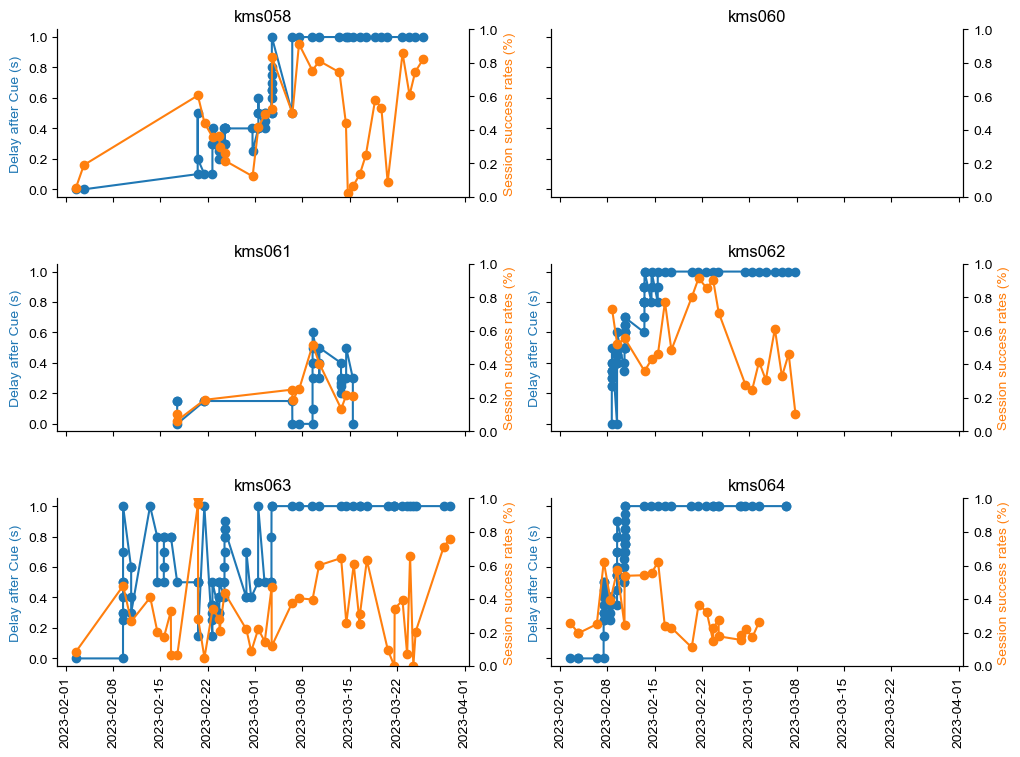

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

cm = 1/2.54  # centimeters in inches
A4 = (29.7*cm, 21*cm)
fig, ax = plt.subplots(ceil(len(subject_ids)/2), 2,
                       sharex=True, sharey=True, figsize=A4)
plt.rcParams['font.family'] = ['Arial']
ax_flat = ax.ravel()

for sbj_idx, sbj in enumerate(subject_ids):

    df_ = df_animals.loc[df_animals.subject_id == sbj, :].copy()
    df_ = df_.reset_index()

    ax1 = ax_flat[sbj_idx]
    ax2 = ax1.twinx()
    ax1.spines['top'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    ax1.set_title(sbj)

    if not  df_.loc[0, 'df_last'].empty:

        ax1.plot(df_.loc[0,'df_v']['datetime'], 
                [v / 1000 for v in df_.loc[0,'df_v']['value']],
                'o-',  color='#1f77b4')
        # ax1.set_xlabel('Date')
        ax1.set_ylabel('Delay after Cue (s)', color='#1f77b4')

        ax2.plot(df_.loc[0,'df_last']['datetime'], df_.loc[0,'df_last']['value'], 'o-', color='#ff7f0e')
        ax2.set_ylabel('Session success rates (%)', color='#ff7f0e')

        # Add a title and legend
        ax1.set_title(sbj)
        # ax1.legend(['Intervals'], loc='upper left')
        # ax2.legend(['Session success rates'], loc='upper right')



        ax2.set_ylim(0,1)

        for label in ax1.get_xticklabels():
                label.set_rotation(90)

plt.subplots_adjust(hspace=0.4)

plt.show()